In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt

from torchsummary import summary
from functools import partial
import pytorch_lightning as pl

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

GPU available: Tesla V100-SXM2-16GB (1 count)


In [6]:
! gsutil cp gs://syrgoth/my-model.epoch_5-step_19885.pkl ./

Copying gs://syrgoth/my-model.epoch_5-step_19885.pkl...
- [1 files][ 18.5 MiB/ 18.5 MiB]                                                
Operation completed over 1 objects/18.5 MiB.                                     


In [3]:
! gsutil cp gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1.ckpt ./

Copying gs://syrgoth/checkpoints/manual_checkpoint_multioutput_lasthidden250_L1.ckpt...
/ [1 files][ 21.4 MiB/ 21.4 MiB]                                                
Operation completed over 1 objects/21.4 MiB.                                     


In [4]:
#Basset
def get_padding(kernel_size):
    left = (kernel_size - 1) // 2
    right= kernel_size - 1 - left
    return [ max(0,x) for x in [left,right] ]

class Conv1dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, 
                 bias=True, batch_norm=True, weight_norm=True):
        super(Conv1dNorm, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride, padding, dilation, groups, bias)
        if weight_norm:
            self.conv = nn.utils.weight_norm(self.conv)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.conv( input ) )
        except AttributeError:
            return self.conv( input )
        
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features, bias=True, 
                 batch_norm=True, weight_norm=True):
        super(LinearNorm, self).__init__()
        self.linear  = nn.Linear(in_features, out_features, bias=True)
        if weight_norm:
            self.linear = nn.utils.weight_norm(self.linear)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_features, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.linear( input ) )
        except AttributeError:
            return self.linear( input )

class Basset(pl.LightningModule):
    r"""Write docstring here.
    """
    
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        
        parser.add_argument('--conv1_channels', type=int, default=300)
        parser.add_argument('--conv1_kernel_size', type=int, default=19)
        
        parser.add_argument('--conv2_channels', type=int, default=200)
        parser.add_argument('--conv2_kernel_size', type=int, default=11)
        
        parser.add_argument('--conv3_channels', type=int, default=200)
        parser.add_argument('--conv3_kernel_size', type=int, default=7)
        
        parser.add_argument('--linear1_channels', type=int, default=1000)
        parser.add_argument('--linear2_channels', type=int, default=1000)
        parser.add_argument('--n_outputs', type=int, default=280)
        
        parser.add_argument('--dropout_p', type=float, default=0.3)
        parser.add_argument('--use_batch_norm', type=utils.str2bool, default=True)
        parser.add_argument('--use_weight_norm',type=utils.str2bool, default=False)
        
        parser.add_argument('--learning_rate', type=float, default=1e-4)
        
        return parser
    
    def __init__(self, conv1_channels=300, conv1_kernel_size=19, 
                 conv2_channels=200, conv2_kernel_size=11, 
                 conv3_channels=200, conv3_kernel_size=7, 
                 linear1_channels=1000, linear2_channels=1000, 
                 n_outputs=280, activation='ReLU', 
                 dropout_p=0.3, use_batch_norm=True, use_weight_norm=False,
                 learning_rate=1e-4):                                                
        super().__init__()
        
        self.conv1_channels    = conv1_channels
        self.conv1_kernel_size = conv1_kernel_size
        self.conv1_pad = get_padding(conv1_kernel_size)
        
        self.conv2_channels    = conv2_channels
        self.conv2_kernel_size = conv2_kernel_size
        self.conv2_pad = get_padding(conv2_kernel_size)

        
        self.conv3_channels    = conv3_channels
        self.conv3_kernel_size = conv3_kernel_size
        self.conv3_pad = get_padding(conv3_kernel_size)
        
        self.linear1_channels  = linear1_channels
        self.linear2_channels  = linear2_channels
        self.n_outputs         = n_outputs
        
        self.activation        = activation
        
        self.dropout_p         = dropout_p
        self.use_batch_norm    = use_batch_norm
        self.use_weight_norm   = use_weight_norm
        
        self.learning_rate     = learning_rate
        
        self.pad1  = nn.ConstantPad1d(self.conv1_pad, 0.)
        self.conv1 = Conv1dNorm(4, 
                                self.conv1_channels, self.conv1_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad2  = nn.ConstantPad1d(self.conv2_pad, 0.)
        self.conv2 = Conv1dNorm(self.conv1_channels, 
                                self.conv2_channels, self.conv2_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad3  = nn.ConstantPad1d(self.conv3_pad, 0.)
        self.conv3 = Conv1dNorm(self.conv2_channels, 
                                self.conv3_channels, self.conv3_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        
        self.pad4 = nn.ConstantPad1d((1,1), 0.)

        self.maxpool_3 = nn.MaxPool1d(3, padding=0)
        self.maxpool_4 = nn.MaxPool1d(4, padding=0)
        
        self.linear1 = LinearNorm(self.conv3_channels*13, self.linear1_channels, 
                                  bias=True, 
                                  batch_norm=self.use_batch_norm, 
                                  weight_norm=self.use_weight_norm)
        self.linear2 = LinearNorm(self.linear1_channels, self.linear2_channels, 
                                  bias=True, 
                                  batch_norm=self.use_batch_norm, 
                                  weight_norm=self.use_weight_norm)
        self.output  = nn.Linear(self.linear2_channels, self.n_outputs)
        
        self.nonlin  = getattr(nn, self.activation)()                               
        
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        hook = self.nonlin( self.conv1( self.pad1( x ) ) )
        hook = self.maxpool_3( hook )
        hook = self.nonlin( self.conv2( self.pad2( hook ) ) )
        hook = self.maxpool_4( hook )
        hook = self.nonlin( self.conv3( self.pad3( hook ) ) )
        hook = self.maxpool_4( self.pad4( hook ) )        
        hook = torch.flatten( hook, start_dim=1 )
        hook = self.dropout( self.nonlin( self.linear1( hook ) ) )
        hook = self.dropout( self.nonlin( self.linear2( hook ) ) )
        output = self.output( hook )
        return output, hook
        
    def training_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = self.criterion(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = self.criterion(logits, y)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [5]:
#MPRA Basset (multi branch)
class MPRA_Basset(pl.LightningModule):
    
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        
        parser.add_argument('--pretrained', type=bool, default=True, 
                            help='True if pretrained basset weights are going to be given')  
        parser.add_argument('--target_width', type=int, default=3, 
                            help='Width (or length) of the target data') 
        parser.add_argument('--learning_rate', type=float, default=1e-4, 
                            help='Value of the learning rate')
        parser.add_argument('--optimizer', type=str, default='Adam', 
                            help='Name of the optimizer')
        parser.add_argument('--scheduler', type=bool, default=True, 
                            help='If true it implements cosine annealing LR')
        parser.add_argument('--weight_decay', type=float, default=1e-6, 
                            help='Weight decay rate')
        parser.add_argument('--epochs', type=int, default=1, 
                            help='Number of epochs passed to the trainer (used by the scheduler)') 
        return parser
    
    def __init__(self,
                 basset_weights_path=None,
                 pretrained=True,
                 target_width=3,
                 learning_rate=1e-4,
                 optimizer='Adam',
                 scheduler=False,
                 weight_decay=1e-6,
                 epochs=1,
                 extra_hidden_size = 100,
                 criterion = 'MSELoss',
                 last_activation='Tanh',
                 sneaky_factor=1,
                 #basset_kwards=None,
                 **kwargs):

        super().__init__()
        self.pretrained = pretrained
        self.basset_weights_path = basset_weights_path
        self.target_width = target_width
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.extra_hidden_size = extra_hidden_size
        self.sneaky_factor = sneaky_factor
        
        self.criterion = getattr(nn, criterion)() #nn.MSELoss()   
        self.last_activation = getattr(nn, last_activation)()
        
        self.basset_net = Basset()
        if self.pretrained:
            try:
                self.basset_net.load_state_dict(torch.load(self.basset_weights_path))
            except:
                self.basset_net.load_state_dict(torch.load(self.basset_weights_path, map_location=torch.device('cpu')))
        
        self.basset_last_hidden_width = self.basset_net.linear2_channels

        self.output_1 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            # nn.Linear(self.extra_hidden_size, self.extra_hidden_size),
            # self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )
        
        self.output_2 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            # nn.Linear(self.extra_hidden_size, self.extra_hidden_size),
            # self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )
        
        self.output_3 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            # nn.Linear(self.extra_hidden_size, self.extra_hidden_size),
            # self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )       
        #self.mpra_output = nn.Linear(self.basset_last_hidden_width, self.target_width)

        self.example_input_array = torch.rand(1, 4, 600)
        
    def forward(self, x):
        _, basset_last_hidden = self.basset_net(x)
        output_1 = self.output_1(basset_last_hidden)
        output_2 = self.output_2(basset_last_hidden)
        output_3 = self.output_3(basset_last_hidden)
        mpra_pred = torch.cat((output_1, output_2, output_3), dim=1)
        #mpra_pred = self.mpra_output(basset_last_hidden)
        return mpra_pred
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        shannon_pred, shannon_target = Shannon_entropy(y_pred), Shannon_entropy(y)
        loss = self.criterion(y_pred, y) + self.sneaky_factor*self.criterion(shannon_pred, shannon_target)
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return {'loss': loss, 'pred': y_pred, 'target': y}
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('test_loss', loss)

    def validation_epoch_end(self, validation_step_outputs):
        preds = torch.cat([out['pred'] for out in validation_step_outputs], dim=0)
        targets  = torch.cat([out['target'] for out in validation_step_outputs], dim=0)
        pearsons, mean_pearson = Pearson_correlation(preds, targets)
        shannon_pred, shannon_target = Shannon_entropy(preds), Shannon_entropy(targets)
        specificity_pearson, specificity_mean_pearson = Pearson_correlation(shannon_pred, shannon_target)
        self.log('Pearson', mean_pearson)
        self.log('Pearson_Shannon', specificity_mean_pearson)
        res_str = '|'
        res_str += ' Prediction correlation: {:.5f} | Specificity correlation: {:.5f} |' \
                    .format(mean_pearson.item(), specificity_mean_pearson.item())
        print(res_str)
        print('-'*len(res_str))
        
    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.optimizer)(self.parameters(), lr=self.learning_rate,
                                                         weight_decay=self.weight_decay)#, amsgrad=True) #I hard-coded amsgrad for Adam  
        if self.scheduler:
            lr_scheduler = {
                'scheduler' : torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.epochs, eta_min=1e-6),
                'name': 'learning_rate'
                           }
            return [optimizer], [lr_scheduler]
        else:
            return optimizer

In [8]:
model = MPRA_Basset(basset_weights_path='my-model.epoch_5-step_19885.pkl',
                    extra_hidden_size = 250,
                    criterion='L1Loss',
                    last_activation='Tanh',
                    sneaky_factor=1,
                    pretrained=True)

if not next(model.parameters()).is_cuda:
    model.cuda()
    print('Model moved to cuda')

checkpoint = torch.load('manual_checkpoint_multioutput_lasthidden250_L1.ckpt')
model.load_state_dict(checkpoint['state_dict'])

Model moved to cuda


<All keys matched successfully>

### Use model with prototype generator

In [10]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','G','T','C']
        self.MPRA_UPSTREAM  = 'ACGAAAATGTTGGATGCTCATACTCGTCCTTTTTCAATATTATTGAAGCATTTATCAGGGTTACTAGTACGTCTCTCAAGGATAAGTAAGTAATATTAAGGTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG'
        self.MPRA_DOWNSTREAM= 'CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCT'
constants = constants()

class utils():
    @staticmethod
    def shannon_entropy(x):
        p_c = nn.Softmax(dim=1)(x)    
        return torch.sum(- p_c * torch.log(p_c), axis=1)

    @staticmethod
    def shannon_entropy_mean(x):
        p_c = nn.Softmax(dim=1)(x)    
        return torch.mean(- p_c * torch.log(p_c))

    @staticmethod
    def neg_reward_loss(x):
        return -torch.sum(x)

    @staticmethod
    def create_paddingTensors(num_sequences, padding_len, num_st_samples=1, for_multi_sampling=True):
        assert padding_len >= 0 and type(padding_len) == int, 'Padding must be a nonnegative integer'
        upPad_logits, downPad_logits = None, None  
        if padding_len > 0:
            assert padding_len <= (len(constants.MPRA_UPSTREAM) + len(constants.MPRA_DOWNSTREAM)), 'Not enough padding available'
            upPad_logits, downPad_logits = utils.dna2tensor(constants.MPRA_UPSTREAM), \
                                        utils.dna2tensor(constants.MPRA_DOWNSTREAM)
            upPad_logits, downPad_logits = upPad_logits[:,-padding_len//2 + padding_len%2:], \
                                        downPad_logits[:,:padding_len//2 + padding_len%2]
            if for_multi_sampling:
                upPad_logits, downPad_logits = upPad_logits.repeat(num_st_samples, num_sequences, 1, 1), \
                                            downPad_logits.repeat(num_st_samples, num_sequences, 1, 1)                                     
            else:
                upPad_logits, downPad_logits = upPad_logits.repeat(num_sequences, 1, 1), \
                                            downPad_logits.repeat(num_sequences, 1, 1)  
        return upPad_logits, downPad_logits

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

In [11]:
class FSP_Parameteres(nn.Module):
    def __init__(self,
                 num_sequences=1,
                 seq_len=200,
                 padding_len=400,
                 num_st_samples=1,
                 vocab_len=4,
                 affine=True,
                 onehot_start=True,
                 **kwrags):
        super().__init__()
        self.num_sequences = num_sequences
        self.seq_len = seq_len  
        self.padding_len = padding_len
        self.num_st_samples = num_st_samples
        self.vocab_len = vocab_len
        self.affine = affine
        self.onehot_start = onehot_start

        self.noise_factor = 0

        self.create_differentiable_input_logits(one_hot=self.onehot_start)

        left_flank, right_flank = utils.create_paddingTensors(self.num_sequences, self.padding_len,
                                                                   self.num_st_samples, True)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)    

        self.instance_norm = nn.InstanceNorm1d(num_features=self.vocab_len, affine=self.affine)  
        
    def forward(self):
        return self.get_samples_as_input()

    def get_distributions(self):
        normalized_logits = self.instance_norm(self.differentiable_logits) + \
            self.noise_factor * torch.randn_like(self.differentiable_logits)
        return F.softmax(normalized_logits, dim=1)

    def get_samples(self):
        softmaxed_logits = self.get_distributions()
        nucleotide_probs = Categorical(torch.transpose(softmaxed_logits, 1, 2))
        sampled_idxs = nucleotide_probs.sample((self.num_st_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.vocab_len)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
        multi_softmaxed_logits = softmaxed_logits.repeat(self.num_st_samples, 1, 1, 1)
        sampled_nucleotides = sampled_nucleotides - multi_softmaxed_logits.detach() + multi_softmaxed_logits #ST estimator trick 
        return sampled_nucleotides
        
    def get_samples_as_input(self):
        sampled_nucleotides = self.get_samples()
        sampled_nucleotides = self.pad(sampled_nucleotides)
        sampled_nucleotides = sampled_nucleotides.view(self.num_st_samples * self.num_sequences, self.vocab_len, -1)
        return sampled_nucleotides

    def get_padded_distributions(self):
        softmaxed_logits = self.get_distributions()
        return self.pad(softmaxed_logits, multi_sampling=False)

    def rebatch(self, input):
        return input.unflatten(0, (self.num_st_samples, self.num_sequences))

    def pad(self, tensor, multi_sampling=True):
        if self.padding_len > 0:
            if not multi_sampling:
                size = tensor.shape
                left_flank, right_flank = self.left_flank[0].view(size), self.right_flank[0].view(size)
                return torch.cat([ left_flank, tensor, right_flank], dim=-1)
            else:
                return torch.cat([ self.left_flank, tensor, self.right_flank], dim=-1)
        else: 
            return tensor

    def create_differentiable_input_logits(self, one_hot=True):
        size = (self.num_sequences, self.vocab_len, self.seq_len)
        if one_hot:
            differentiable_logits = np.zeros(size)
            for seqIdx in range(self.num_sequences):
                for step in range(self.seq_len):
                    randomNucleotide = np.random.randint(self.vocab_len)
                    differentiable_logits[seqIdx, randomNucleotide, step] = 1       
            self.differentiable_logits = nn.Parameter(torch.tensor(differentiable_logits, dtype=torch.float))  
        else:
            self.differentiable_logits = nn.Parameter(torch.randn(size))

In [12]:
class FastSeqProp(nn.Module):
    def __init__(self,
                 fitness_fn,
                 params,
                 loss_fn,
                 **kwargs):
        super().__init__()
        self.fitness_fn = fitness_fn
        self.params = params
        self.loss_fn = loss_fn                              

        try: fitness_fn.eval()
        except: pass
    
    def optimize(self, steps=20, learning_rate=0.5, step_print=5, lr_scheduler=True, noise_factor=0):          
        self.params.noise_factor = noise_factor
        if lr_scheduler:
            etaMin = 1e-6
        else:
            etaMin = learning_rate
        optimizer = torch.optim.Adam(self.params.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps, eta_min=etaMin)      
        loss_hist = []
        for step in range(1, steps+1):
            optimizer.zero_grad()
            sampled_nucleotides = self.params()
            fitnesses = self.fitness_fn(sampled_nucleotides)
            loss = self.loss_fn(fitnesses)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_hist.append(loss.item())
            self.params.noise_factor = self.params.noise_factor / np.sqrt(step)
            if step % step_print == 0:
                print(f'step: {step}, loss: {round(loss.item(),6)}, learning_rate: {scheduler.get_last_lr()}, noise factor: {self.params.noise_factor}')                      
        self.params.noise_factor = 0
        self.loss_hist = loss_hist
        plt.plot(loss_hist)
        plt.xlabel('Steps')
        vert_label=plt.ylabel('Loss')
        vert_label.set_rotation(90)
        plt.show()

step: 20, loss: 0.010841, learning_rate: [0.4877641535455303], noise factor: 3.205587942683902e-11
step: 40, loss: 0.009268, learning_rate: [0.4522543440852398], noise factor: 5.535380382431696e-26
step: 60, loss: 0.008678, learning_rate: [0.3969465191804924], noise factor: 5.481287471136054e-43
step: 80, loss: 0.008742, learning_rate: [0.3272545940852398], noise factor: 1.8689864082375674e-61
step: 100, loss: 0.008662, learning_rate: [0.2500005000000002], noise factor: 5.175689055878133e-81
step: 120, loss: 0.008546, learning_rate: [0.17274640591476056], noise factor: 1.9331835044937796e-101
step: 140, loss: 0.008423, learning_rate: [0.10305448081950795], noise factor: 1.3627462951100945e-122
step: 160, loss: 0.008324, learning_rate: [0.04774665591476038], noise factor: 2.3027239819684916e-144
step: 180, loss: 0.008346, learning_rate: [0.012236846454469772], noise factor: 1.1155378025706445e-166
step: 200, loss: 0.008297, learning_rate: [1e-06], noise factor: 1.7804332011346016e-189


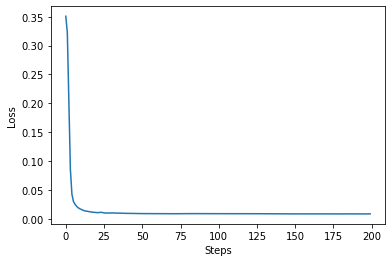

In [15]:
#create parameters
params = FSP_Parameteres(num_sequences=100,
                        num_st_samples=20,
                        affine=True,
                        onehot_start=False)

#create generator
generator = FastSeqProp(fitness_fn=model,
                        params=params,
                        loss_fn=utils.shannon_entropy_mean)
generator.cuda()

#optimize parameters
generator.optimize(steps=200,
                   learning_rate=0.5,
                   step_print=20,
                   lr_scheduler=True,
                   noise_factor=0.05)

In [16]:
samples = params.get_samples_as_input()
predictions = model(samples)
avg_preds = params.rebatch(predictions).mean(dim=0)
distributions = params.get_distributions()

In [18]:
avg_preds

tensor([[ 5.9037, -0.8753, -0.9666],
        [ 5.8349, -0.8168, -0.7947],
        [ 5.7480, -0.9180, -0.9763],
        [ 5.8773, -0.8818, -0.9727],
        [ 5.7991, -0.5571, -0.5105],
        [ 5.9983, -0.8575, -0.8413],
        [ 5.9465, -0.9657, -1.0392],
        [ 5.8168, -0.7355, -0.7128],
        [ 5.8046, -0.9048, -1.0015],
        [ 5.8657, -0.9192, -0.9852],
        [ 5.9493, -0.8801, -0.8473],
        [ 5.9880, -0.9104, -0.9877],
        [ 5.9051, -0.9309, -1.0493],
        [ 5.8876, -0.8957, -0.9283],
        [ 5.8848, -0.9168, -0.9543],
        [ 5.6005, -0.8775, -0.9423],
        [ 5.9397, -0.8636, -0.7724],
        [ 5.9156, -0.8145, -0.7326],
        [ 5.9196, -0.9074, -1.0214],
        [ 5.8784, -0.8345, -0.9318],
        [ 5.8677, -0.8606, -0.9517],
        [ 5.8953, -0.8786, -0.8118],
        [ 5.9178, -0.8752, -0.8669],
        [ 6.0605, -0.9129, -0.9933],
        [ 5.9182, -0.8703, -0.9220],
        [ 5.8031, -0.8515, -0.8777],
        [ 5.8570, -0.9274, -0.9959],
 